In [48]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import re
import nltk
import os
import smart_open
import collections
import scipy.stats as stats
import tensorflow as tf
import gensim

from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import common_texts
from gensim.test.utils import get_tmpfile

import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import Sequential, Model
#from tensorflow.keras import backend as K
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, Adadelta, Nadam, Adagrad, Adamax, Ftrl, RMSprop, SGD #schedules
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, Dense, Flatten, LSTM, Conv1D, Conv2D, GlobalAveragePooling1D, Conv2D, ZeroPadding2D
from tensorflow.keras.layers import Bidirectional, GlobalAveragePooling2D, GlobalAveragePooling3D, BatchNormalization, Dropout
from tensorflow.keras.layers import Subtract, Add, Multiply, Activation, Input, Concatenate, Reshape, Dot, GRU, Lambda, Layer 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#import keras as K

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
#from sklearn.model_selection import GridSearchCV, RandomSearch
from sklearn.ensemble import RandomForestClassifier

from sklearn import svm, tree
import xgboost


In [2]:
path = '/Users/patrickrs/Documents/GitLab/revealapp/10_cleaning/src'

current_path = os.getcwd()
os.chdir(path)
%run ./Load+Clean_News.ipynb
%run ./cont_to_cat_News.ipynb
os.chdir(current_path)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrickrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data = news

In [4]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = \
train_test_split(data['sentence1'], data['sentence2'], data['sim'], 
                 test_size=0.2, random_state=42)

In [6]:
elmo_layer = hub.KerasLayer("https://tfhub.dev/google/elmo/3", 
                            output_shape=[1024], 
                            input_shape=[1], 
                            dtype=tf.string, 
                            trainable=True,
                            name = "elmo_layer")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [31]:
feat1_train = elmo_layer(tf.convert_to_tensor(X1_train)).numpy()

In [32]:
feat2_train = elmo_layer(tf.convert_to_tensor(X2_train)).numpy()

In [33]:
feat1_test = elmo_layer(tf.convert_to_tensor(X1_test)).numpy()

In [34]:
feat2_test = elmo_layer(tf.convert_to_tensor(X2_test)).numpy()

In [38]:
cs_train = []
for i in range(len(feat1_train)):
    cs_temp = cosine_similarity(feat1_train[i].reshape(1, -1), feat2_train[i].reshape(1, -1))
    cs_temp = cs_temp[0][0]
    cs_train.append(cs_temp)
cs_train = np.array(cs_train).reshape(-1, 1)

In [41]:
cs_test = []
for i in range(len(feat1_test)):
    cs_temp = cosine_similarity(feat1_test[i].reshape(1, -1), feat2_test[i].reshape(1, -1))
    cs_temp = cs_temp[0][0]
    cs_test.append(cs_temp)
cs_test = np.array(cs_test).reshape(-1, 1)

In [45]:
logit = LogisticRegression(class_weight = 'balanced')
clf = logit.fit(X = cs_train, y = y_train)
y_pred = clf.predict(cs_test)
acc_baseline = accuracy_score(y_true = y_test, y_pred = y_pred)
acc_baseline

0.732824427480916

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.839


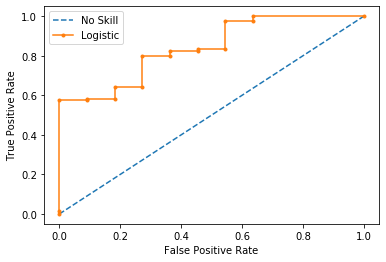

In [49]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = logit.predict_proba(cs_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()